28.11.2023 Meeting

Overview:

[x] Visualize predicted vs true values (scatterplot with seaborn) of model predicting click difference from difference embedding (true difference - predicted difference)

[x] show headlines that scored highly and compare with headlines scored low 

[ ] compare ranking between model using embeddings and embedding difference to predict clicks / click difference

[x] make list of potential explanations of what the model is capturing (speech text / punctuation)

[x] introducing click rate

 

In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.linear_model import RidgeCV, LogisticRegression, LinearRegression
from torch.utils.data import DataLoader, TensorDataset
import csv
import torch 
import pickle
import random
from sklearn.metrics import accuracy_score
from scipy.stats import spearmanr
import math

In [2]:
#cpu/gpu
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

No GPU available, using the CPU instead.


In [3]:
#Define model - pretrained
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
#model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')


In [4]:
#Load data
df = pd.read_csv("C:/Users/mldem/Downloads/upworthy-archive-datasets/upworthy-archive-confirmatory-packages-03.12.2020.csv", low_memory=False)
#Delete some unnecessary columns
print(df.columns)
delete_cols = ["created_at","updated_at","share_text","square"]
df = df.drop(columns=delete_cols)
#Create a new column for clickrate
df["clickrate"] = round((df["clicks"]/ df["impressions"]),ndigits=3)
print(df.groupby(["clickability_test_id"]).count().mean()) #average of 4.64 packages within one test
print(df.groupby(["clickability_test_id","eyecatcher_id"]).count().mean()) #average of 2.11 packages with the same eyecatcher id and same clickability_test_id
clicks =torch.tensor(df.clicks.values)

Index(['Unnamed: 0', 'created_at', 'updated_at', 'clickability_test_id',
       'excerpt', 'headline', 'lede', 'slug', 'eyecatcher_id', 'impressions',
       'clicks', 'significance', 'first_place', 'winner', 'share_text',
       'square', 'test_week'],
      dtype='object')
Unnamed: 0       4.641032
excerpt          4.147870
headline         4.641032
lede             4.638130
slug             4.641032
eyecatcher_id    4.635272
impressions      4.641032
clicks           4.641032
significance     4.641032
first_place      4.641032
winner           4.641032
test_week        4.641032
clickrate        4.641032
dtype: float64
Unnamed: 0      2.117931
excerpt         1.892597
headline        2.117931
lede            2.116605
slug            2.117931
impressions     2.117931
clicks          2.117931
significance    2.117931
first_place     2.117931
winner          2.117931
test_week       2.117931
clickrate       2.117931
dtype: float64


In [5]:
#Load embeddings
with open('full_embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_sentences = stored_data['headlines']
    stored_embeddings = stored_data['embeddings']



# 1. Predicting clicks from headline embeddings with ridge regression (incl. comparison with linear)

In [6]:
# Model
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, clicks, test_size=0.2)

In [7]:
# Ridge Model
ridge_model =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_model.fit(X_train, y_train)
ridge_model.score(X_train,y_train) #0.1629
predictions = ridge_model.predict(X_test) #alpha = 10
rmse = mean_squared_error(y_test, predictions)
print("Ridge Regression MSE for click difference:", rmse)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=predictions))
df["predictions"] = ridge_model.predict(stored_embeddings)
print("Spearman correlation:",spearmanr(df.sort_values(["predictions"]).loc[:,"headline"],df.sort_values(["clicks"]).loc[:,"headline"]))



Ridge Regression MSE for click difference: 1680.7123980704882
Ridge Regression R2 for click difference: 0.15630751841239166
Spearman correlation: SignificanceResult(statistic=-0.0003500375600872288, pvalue=0.909458959910692)


### Last 20

In [8]:
from ipywidgets import widgets, Layout
from IPython import display

last20_pred = df.sort_values(["predictions"],ascending=True).loc[:,['headline']][:20]
last20_true = df.sort_values(["clicks"],ascending=True).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(last20_pred.style.set_caption('Last 20 Predicted'))
    last20_pred.info()
with widget2:
    display.display(last20_true.style.set_caption('Last 20 True'))
    last20_true.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [9]:
#Checking for intersection
np.intersect1d(last20_pred.values,last20_true.values)

array([], dtype=object)

#### Potential explanations: PREDICTED
#### 1. Short sentences
#### 2. Capital letters
#### 3. Punctuation - exlamation marks, question marks

#### Potential explanations: TRUE
#### 1. No famous names
#### 2. Focus on the reader - imagine if, what would happen if you

## Top 20

In [10]:
top20_pred = df.sort_values(["predictions"],ascending=False).loc[:,['headline']][:20]
top20_true = df.sort_values(["clicks"],ascending=False).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(top20_pred.style.set_caption('Top 20 Predicted'))
    last20_pred.info()
with widget2:
    display.display(top20_true.style.set_caption('Top 20 True'))
    last20_true.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box


In [11]:
#Checking for intersection
np.intersect1d(top20_pred.values,top20_true.values)

array([], dtype=object)

#### Potential explanations:
#### 1. Call to action words - "Watch"
#### 2. Capital letters

### Ridge with clickrate instead of clicks

In [12]:

clickrate =torch.tensor(df.clickrate.values)

X_train, X_test, y_train, y_test = train_test_split(stored_embeddings,clickrate, test_size=0.2)
# Ridge Model

ridge_model_clickrate =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_model_clickrate.fit(X_train, y_train)
ridge_model_clickrate.score(X_train,y_train) #0.1629
predictions_clickrate = ridge_model_clickrate.predict(X_test) #alpha = 10
rmse_clickrate = mean_squared_error(y_test, predictions_clickrate)

predictions_clickrate_all = ridge_model_clickrate.predict(stored_embeddings)
print(predictions_clickrate_all.shape[0])


for i in range(predictions_clickrate_all.shape[0]):
    if predictions_clickrate_all[i] < 0:
        predictions_clickrate_all[i] = 0
        
df["predictions_clickrate_all"] = predictions_clickrate_all

print("Ridge Regression MSE for click difference:", rmse_clickrate)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=predictions_clickrate))






105551
Ridge Regression MSE for click difference: 0.0001322246962630962
Ridge Regression R2 for click difference: 0.168094577567668


### Last 20 clickrate

In [13]:
last20_pred = df.sort_values(["predictions_clickrate_all"],ascending=True).loc[:,['headline']][:20]
last20_true = df.sort_values(["clickrate"],ascending=True).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(last20_pred.style.set_caption('Last 20 Predicted'))
    last20_pred.info()
with widget2:
    display.display(last20_true.style.set_caption('Last 20 True'))
    last20_true.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box


In [14]:
#Checking for intersection
np.intersect1d(last20_pred.values,last20_true.values)

array([], dtype=object)

#### Potential explanations:
#### 1. Questions
#### 2. Topics about the future - i.e food shortage, water supply, preparing for tornadoes

### Top 20 clickrate


In [15]:
top20_pred = df.sort_values(["predictions_clickrate_all"],ascending=False).loc[:,['headline']][:20]
top20_true = df.sort_values(["clickrate"],ascending=False).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(top20_pred.style.set_caption('Top 20 Predicted'))
    last20_pred.info()
with widget2:
    display.display(top20_true.style.set_caption('Top 20 True'))
    last20_true.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [16]:
#Checking for intersection
np.intersect1d(top20_pred.values,top20_true.values)

array([], dtype=object)

#### Potential explanations:
#### 1. Call to action words - "Watch"
#### 2. Capital letters

## Linear Model

In [17]:
# Linear Model
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, clicks, test_size=0.2)
linear_model =LinearRegression()
linear_model.fit(X_train, y_train)
linear_model.score(X_train,y_train) #0.1643
predictions = linear_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Linear Regression MSE for clicks:", rmse)
print("Linear Regression R2 for clicks:", r2_score(y_true=y_test, y_pred=predictions))

Linear Regression MSE for clicks: 42.04184700400173
Linear Regression R2 for clicks: 0.1547277546761353


### Visualizing predicted clicks vs actual clicks

143.6074240705225


(-100.0, 800.0)

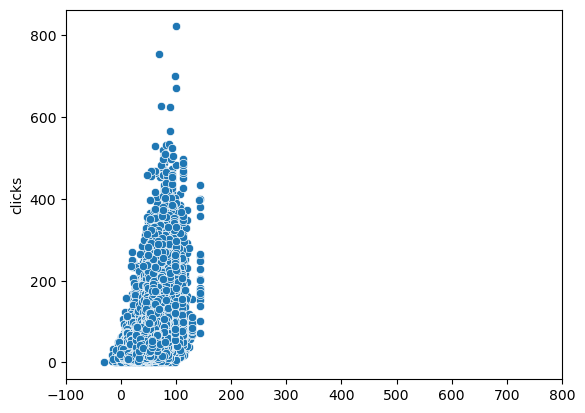

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
# print stuff. 
predictions = ridge_model.predict(stored_embeddings)
print(predictions.max())
# visualize real and predicted values
fig, ax = plt.subplots()
sns.scatterplot(x = predictions, y = df['clicks'], ax=ax)
ax.set_xlim(-100,800)


## Extra:MLP Regressor model 

In [19]:
from sklearn.neural_network import MLPRegressor
MLP_regressor = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
predictions_mlp = MLP_regressor.predict(X_test)
r2_score(y_true=y_test,y_pred=predictions_mlp)


C:\Users\mldem\anaconda3\envs\causalclicker\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.5275308844437705

(-100.0, 800.0)

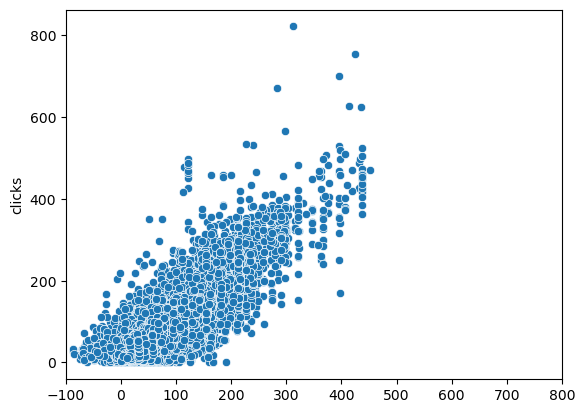

In [20]:

predictions_all = MLP_regressor.predict(stored_embeddings)

# visualize real and predicted values
fig, ax = plt.subplots()
sns.scatterplot(x = predictions_all, y = df['clicks'], ax=ax)
ax.set_xlim(-100,800)


In [21]:
#Pair headlines based on clickability_test_id and eyecatcher_id
#Import dataset with pairs
df_pairs = pd.read_csv("headline_pair_indices.csv")
#Compute vector difference
embedding_diff = torch.stack(df_pairs.apply(lambda row: stored_embeddings[row['Idx_Headline1']] - stored_embeddings[row['Idx_Headline2']], axis=1).tolist()) 
#because we have a column where each row is a tensor so we kinda unpack them.
#Sort pairs s.t. headline1 is headline with more clicks. 
df_sorted_pairs = df_pairs.copy()
df_sorted_pairs.loc[~df_sorted_pairs["headline1_more_clicks"], ['Idx_Headline1', 'Idx_Headline2']] = df_sorted_pairs.loc[~df_sorted_pairs["headline1_more_clicks"], ['Idx_Headline2', 'Idx_Headline1']].values
df_sorted_pairs['click_difference'] = abs(df_pairs['click_difference'])

# 2 Predicting Headline-Winner based on SBert Embeddings with Logistic Regression

In [22]:
headline1_more_clicks = torch.tensor(df_pairs['headline1_more_clicks'])
X_train, X_test, y_train, y_test = train_test_split(embedding_diff, headline1_more_clicks, test_size=0.2)
logistic = LogisticRegression(max_iter=200)
logistic.fit(X_train, y_train)
predicted_logistic = logistic.predict(X_test)
accuracy_logistic = accuracy_score(predicted_logistic,y_test)
print("Accuracy predicting winner:", accuracy_logistic)

Accuracy predicting winner: 0.6270825948245303


# 3 Predicting Click difference based on SBert embeddings with Ridge Regression

In [23]:
#check shape matching and turning into tensors to work
clicks_diff = torch.tensor(df_sorted_pairs['click_difference'])

#take sorted embeddings 
sorted_embedding_diff = torch.stack(df_sorted_pairs.apply(lambda row: stored_embeddings[row['Idx_Headline1']] - stored_embeddings[row['Idx_Headline2']], axis=1).tolist()) 

In [24]:
#Based on difference vector
X_train, X_test, y_train, y_test = train_test_split(sorted_embedding_diff, clicks_diff, test_size=0.2, random_state=seed)
ridge_model_diff =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_fit_diff = ridge_model_diff.fit(X_train, y_train)
ridge_fit_diff.score(X_train,y_train) #0.09528
ridge_predictions_diff = ridge_model_diff.predict(X_test)
ridge_rmse_diff = mean_squared_error(y_test, ridge_predictions_diff)
df_sorted_pairs["predictions"] = ridge_model_diff.predict(sorted_embedding_diff)
print("Ridge Regression MSE for clicks difference:", ridge_rmse_diff)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=ridge_predictions_diff)) 

Ridge Regression MSE for clicks difference: 250.27313508886158
Ridge Regression R2 for click difference: 0.03849809185468611


### Last 20 winners with the smallest click difference

In [25]:
last20_pred = df.loc[df_sorted_pairs.sort_values(["predictions"], ascending=True).loc[:,'Idx_Headline1'][:20], ['headline']]
last20_true =df.loc[df_sorted_pairs.sort_values(["click_difference"], ascending=True).loc[:,'Idx_Headline1'][:20], ['headline']]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(last20_pred.style.set_caption('Last 20 Predicted'))
    last20_pred.info()
with widget2:
    display.display(last20_true.style.set_caption('Last 20 True'))
    last20_true.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box




In [26]:
## checking for intersection
# looking at top 200 we get 3 overlaps.
np.intersect1d(last20_pred.values,last20_true.values)

array([], dtype=object)

In [27]:
#### Possible explanations:
#### 1.
#### 2.

### Top 20 - winners with highest click difference


In [28]:
top20_pred = df.loc[df_sorted_pairs.sort_values(["predictions"], ascending=False).loc[:,'Idx_Headline1'][:20], ['headline', 'clicks']]
top20_true = df.loc[df_sorted_pairs.sort_values(["click_difference"], ascending=False).loc[:,'Idx_Headline1'][:20], ['headline', 'clicks']]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(top20_pred.style.set_caption('Top 20 Predicted'))
    last20_pred.info()
with widget2:
    display.display(top20_true.style.set_caption('Top 20 True'))
    last20_true.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box



#### Posible explanations:
#### 1. Beginning of a story - i.e a man screamed, an interviewer asks..
#### 2. Capital letters

(-100.0, 450.0)

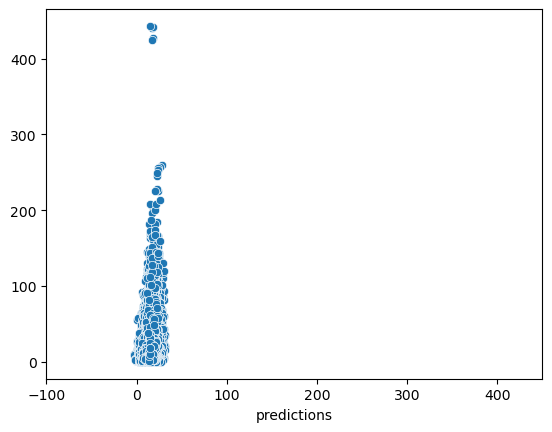

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
# visualize real and predicted values
fig, ax = plt.subplots()
sns.scatterplot(x = df_sorted_pairs['predictions'], y = clicks_diff, ax=ax)
ax.set_xlim(-100,450)
## this is super sketchy. 

### Compare headline ranking between true click difference and predicted click difference

In [30]:


# there has to be a better way!
predicted_ranking = df_sorted_pairs.sort_values(['predictions'])['Idx_Headline1'].astype(str).values+df_sorted_pairs.sort_values(['predictions'])['Idx_Headline2'].astype(str).values
true_ranking = df_sorted_pairs.sort_values(['click_difference'])['Idx_Headline1'].astype(str).values+df_sorted_pairs.sort_values(['click_difference'])['Idx_Headline2'].astype(str).values

print("Spearman correlation is",spearmanr(predicted_ranking, true_ranking))

Spearman correlation is SignificanceResult(statistic=0.0024772582321204713, pvalue=0.43634106792463767)


# Extra: Prediction based on concatenated full embeddings

In [31]:
## Here we need to make sure the headline ordering is correct so we use sorted pairs 
#Compute concatenated embeddings of the pairs
vec1 = df_sorted_pairs.apply(lambda row:(stored_embeddings[row['Idx_Headline1']]), axis=1)
vec1= torch.stack(vec1.tolist())
vec2 = df_sorted_pairs.apply(lambda row:(stored_embeddings[row['Idx_Headline2']]), axis=1)
vec2= torch.stack(vec2.tolist())
concatenated_vector = torch.cat([vec1, vec2], dim=1)
print(concatenated_vector)

tensor([[-0.0639,  0.1315, -0.1852,  ...,  0.1781,  0.1700, -0.2824],
        [ 0.0265,  0.0478,  0.2955,  ...,  0.1285, -0.0735, -0.2070],
        [ 0.0265,  0.0478,  0.2955,  ..., -0.5914,  0.7509, -0.2418],
        ...,
        [ 0.2242, -0.0074, -0.0443,  ...,  0.0541, -0.1859, -0.2557],
        [ 0.1863, -0.0445, -0.3540,  ...,  0.0511,  0.0482, -0.0710],
        [ 0.2242, -0.0074, -0.0443,  ...,  0.0511,  0.0482, -0.0710]])


In [32]:
#Based on concatenated full embeddings
X_train, X_test, y_train, y_test = train_test_split(concatenated_vector, clicks_diff, test_size=0.2)

In [33]:
# Ridge Model
ridge_model_diff =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_fit_diff = ridge_model_diff.fit(X_train, y_train)
ridge_fit_diff.score(X_train,y_train) #0.01513
ridge_predictions_diff = ridge_model_diff.predict(X_test)
ridge_rmse_diff = mean_squared_error(y_test, ridge_predictions_diff)
print("Ridge Regression MSE for clicks difference:", ridge_rmse_diff)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=ridge_predictions_diff)) 


Ridge Regression MSE for clicks difference: 238.4444706903468
Ridge Regression R2 for click difference: 0.08570904061331208


In [34]:
# Linear Model
lin_model_diff = LinearRegression()
lin_fit_diff = lin_model_diff.fit(X_train, y_train)
lin_fit_diff.score(X_train,y_train)
lin_predictions_diff = lin_model_diff.predict(X_test)
lin_rmse_diff = mean_squared_error(y_test, lin_predictions_diff)
print("Linear Regression MSE for clicks difference:", lin_rmse_diff) #Result is better with linear regression
print("Linear Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=lin_predictions_diff)) 

Linear Regression MSE for clicks difference: 238.509803371365
Linear Regression R2 for click difference: 0.08545852912342733
